## Setup
#### Import libraries

In [49]:
%matplotlib inline

import sys
import numpy as np
import scipy.sparse as ssp
import pandas as pd
import os
import matplotlib.pyplot as plt
#import scrublet as scr
import scanpy as sc
import time
# !!!!

# Change this path to point to folder containing helper_functions.py
sys.path.append('/Users/ignas/Dropbox (HMS)/HMS_Klein-lab')
import helper_functions as hf


#### Set up display parameters for nicer looking plots

In [50]:
hf.set_plot_defaults(fontsize=12)


## Load the data

In [138]:
#Different HEK293t and 3t3 conditions
D_cells = {}
samples = []
for matrix in os.listdir('data/HEK_3t3_conditions/'):
    name = matrix.split('.')[0]
    D_cells[name] = sc.read_h5ad(f'data/HEK_3t3_conditions/{matrix}')
    D_cells[name].obs_names_make_unique
    samples.append(name)

/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_m

In [139]:
#K562 fresh and fixed cells
for matrix in os.listdir('data/PFA_fixation/'):
    name = matrix.split('.')[0]
    D_cells[name] = sc.read_h5ad(f'data/PFA_fixation/{matrix}')
    D_cells[name].obs_names_make_unique
    samples.append(name)

In [120]:
samples

['Media_dextranase_3t3',
 'Media_dextranase_rep_HEK293t',
 'Frozen_3t3',
 'Media_dextranase_rep_3t3',
 'Media_dextranase_HEK293t',
 'Frozen_HEK293t',
 'DPBS_HEK293t',
 'DPBS_dextranase_HEK293t',
 'DPBS_3t3',
 'DPBS_dextranase_3t3',
 'Fresh_K562',
 'Fixed_K562']

In [54]:
import scipy.stats as scs

In [55]:
def plot_gene_gene_scatter(adata, s1, s2, lines, label1, label2):
    fig, ax = plt.subplots(1, 2, figsize=(5.8,2.8), dpi = 200)
    
    #Iterate over cell lines used
    for iL, line in enumerate(lines):
        
        #Take QQ downsampled data and normalized it to TPMs
        x = ((adata[s1+'_' + line].layers['Q-Q_normalized'].A.T/adata[s1+'_' + line].layers['Q-Q_normalized'].A.sum(1))*1e6).mean(1)
        y = ((adata[s2+'_' + line].layers['Q-Q_normalized'].A.T/adata[s2+'_' + line].layers['Q-Q_normalized'].A.sum(1))*1e6).mean(1)
        
        #Plot the scatter
        ax[iL].scatter(x,y, marker = 'o', facecolors = 'None', edgecolors='black',s=4, alpha = 0.1)
        
        #Add R2
        r2 = scs.pearsonr(np.log10(x+1), np.log10(y+1))[0]**2
        ax[iL].text(0.3, 5000, '$R^2$ = ' + str(np.round(r2, 3)), fontsize = 12)

    for ax in ax:
        ax.set_xlim(0.1, 1e5)
        ax.set_ylim(0.1, 1e5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([0.1, 10, 1000, 100000])
        ax.set_xlabel(label1, fontsize = 12)
        ax.set_ylabel(label2, fontsize = 12)
    plt.tight_layout()

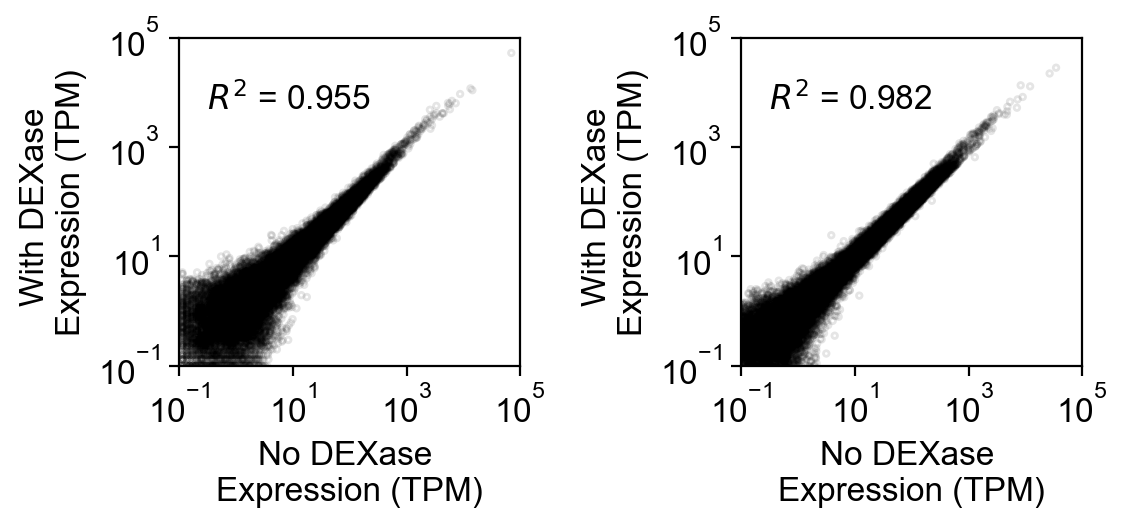

In [36]:
plot_gene_gene_scatter(D_cells,
                       'DPBS',
                       'DPBS_dextranase',
                       lines = ['HEK293t', '3t3'],
                       label1 = 'No DEXase \nExpression (TPM)',
                       label2 = 'With DEXase \nExpression (TPM)')

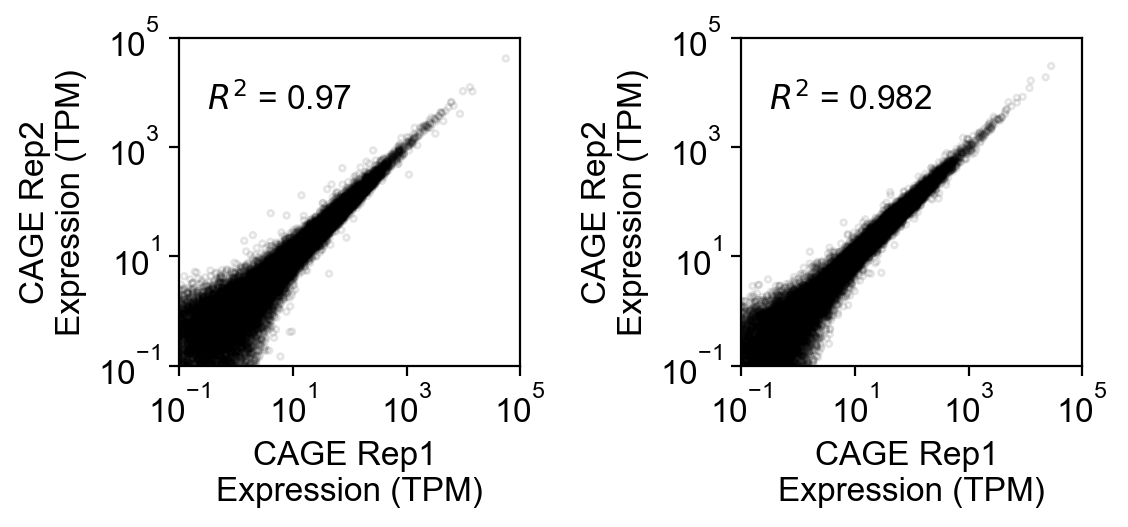

In [37]:
plot_gene_gene_scatter(D_cells,
                       'Media_dextranase',
                       'Media_dextranase_rep',
                       lines = ['HEK293t', '3t3'],
                       label1 = 'CAGE Rep1 \nExpression (TPM)',
                       label2 = 'CAGE Rep2  \nExpression (TPM)')

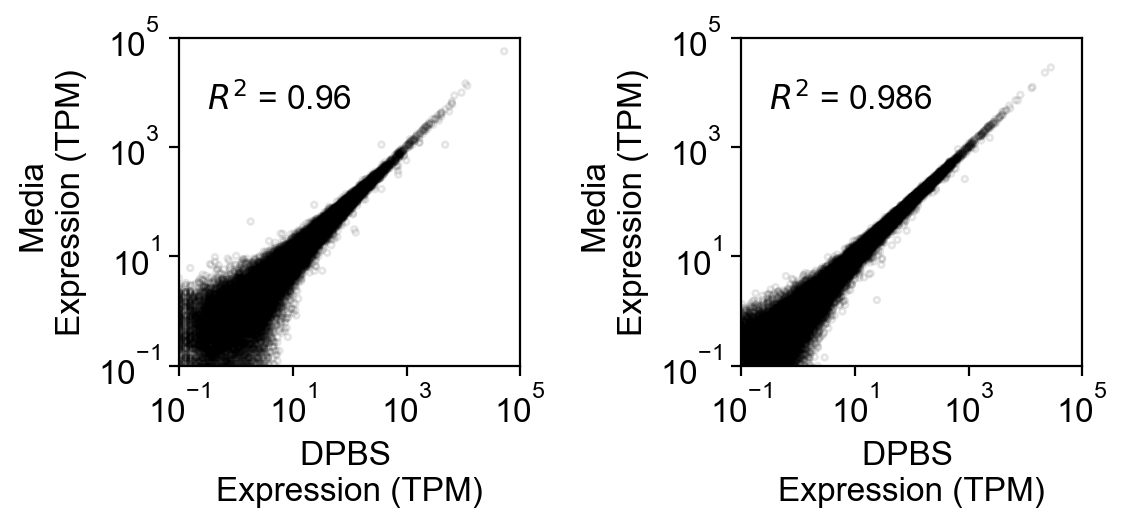

In [38]:
plot_gene_gene_scatter(D_cells,
                       'DPBS_dextranase',
                       'Media_dextranase',
                       lines = ['HEK293t', '3t3'],
                       label1 = 'DPBS \nExpression (TPM)',
                       label2 = 'Media \nExpression (TPM)')

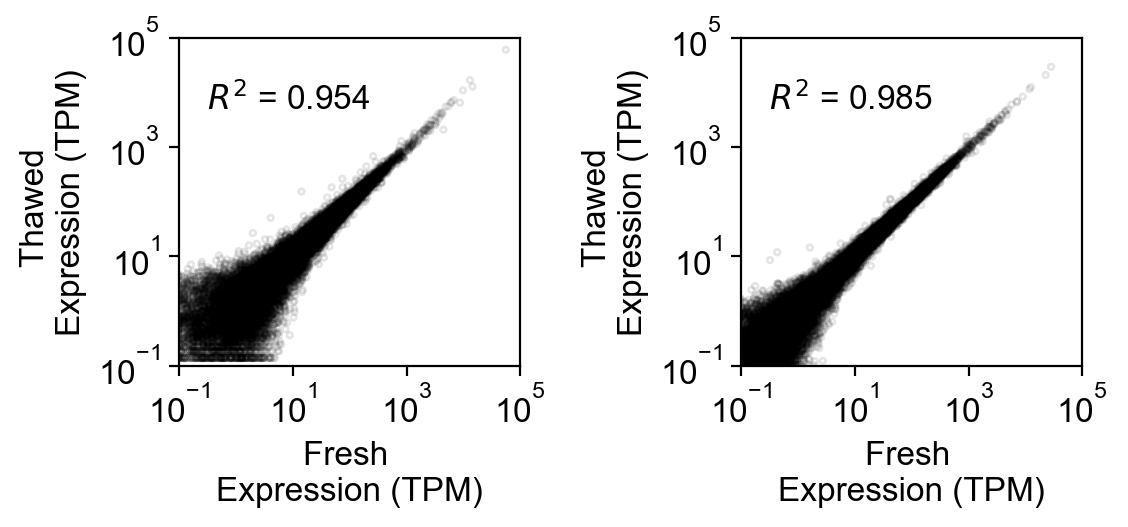

In [39]:
plot_gene_gene_scatter(D_cells,
                       'Media_dextranase',
                       'Frozen',
                       lines = ['HEK293t', '3t3'],
                       label1 = 'Fresh \nExpression (TPM)',
                       label2 = 'Thawed \nExpression (TPM)')

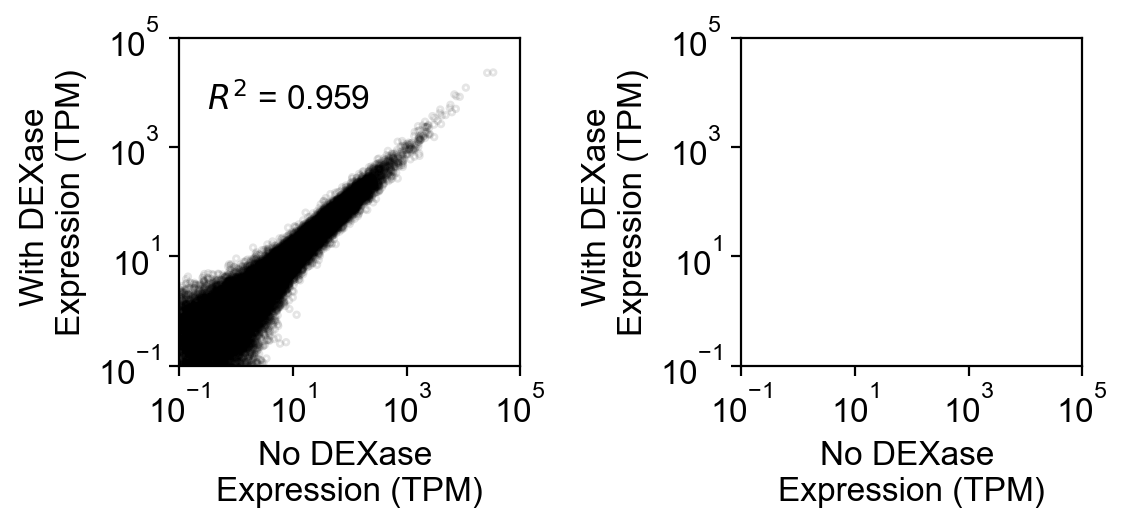

In [56]:
plot_gene_gene_scatter(D_cells,
                       'Fresh',
                       'Fixed',
                       lines = ['K562'],
                       label1 = 'No DEXase \nExpression (TPM)',
                       label2 = 'With DEXase \nExpression (TPM)')

## UMI plots

In [111]:
def plot_saturation(adata, s1, s2, lines):
    
    fig, ax = plt.subplots(1, 2, figsize=(4,3.5), dpi = 200)
    #Iterate over cell lines used
    for iL, line in enumerate(lines):
        x = adata[s1+'_'+line].uns['read_sampling']
        y = adata[s1+'_'+line].uns['umi_sampling']
        ax[iL].plot(x, y, 'o-', markersize=5, linewidth=1, label = s1, color ='teal')

        x = adata[s2+'_'+line].uns['read_sampling']
        y = adata[s2+'_'+line].uns['umi_sampling']
        ax[iL].plot(x, y, 'o-', markersize=5, linewidth=1, label =s2, color ='black')
    

    for ax in ax:
        ax.set_xlim(0, 25e3)
        ax.set_ylim(0, 15e3)

        ax.set_xlabel(r'Reads/cell ($x10^{3}$)')
        ax.set_ylabel(r'UMI/cell ($x10^{3}$)')

        fig.tight_layout()
        ax.set_xticks([0, 10e3,  20e3])
        ax.set_xticklabels([0, 10, 20])

        ax.set_yticks([0, 4e3, 8e3,12e3, 16e3])
        ax.set_yticklabels([0, 4, 8, 12, 16])


        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
                  ncol=1, fancybox=True, shadow=True, fontsize = 7)
        


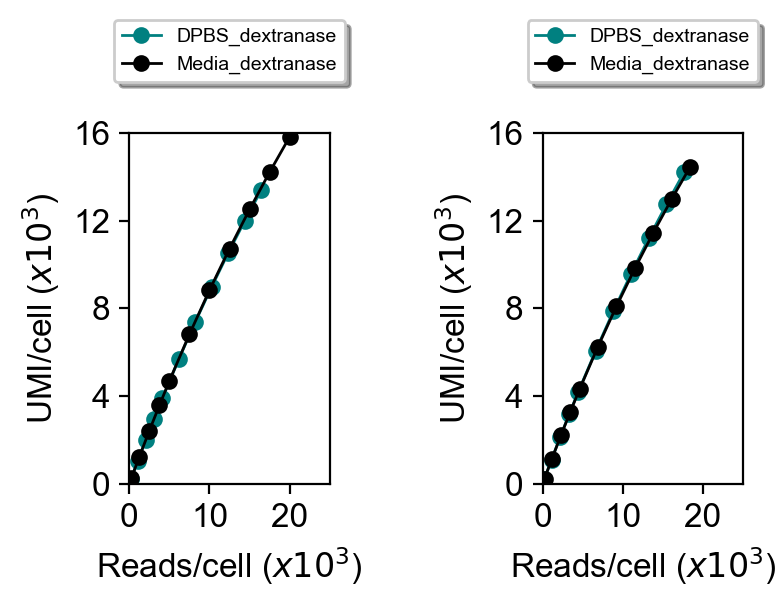

In [114]:
plot_saturation(D_cells,
                'DPBS_dextranase',
                'Media_dextranase',
                ['HEK293t', '3t3'])

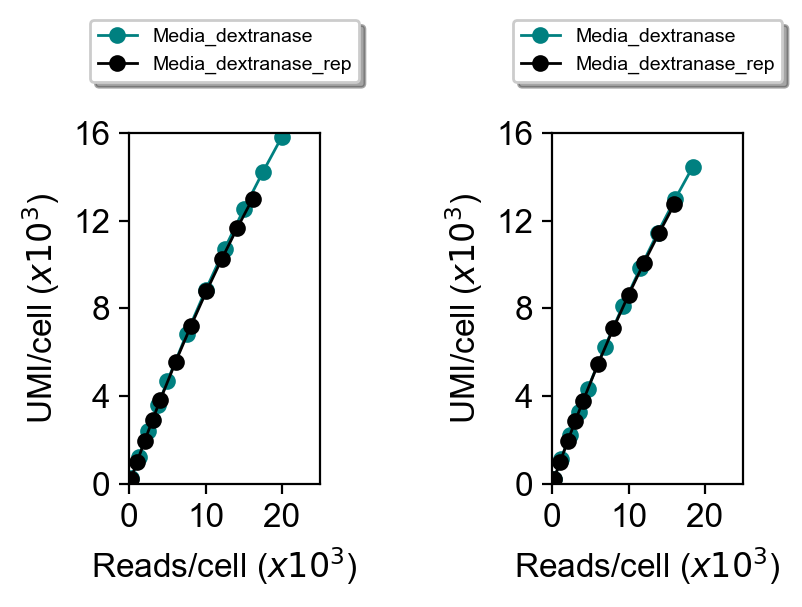

In [113]:
plot_saturation(D_cells,
                'Media_dextranase',
                'Media_dextranase_rep',
                ['HEK293t', '3t3'])

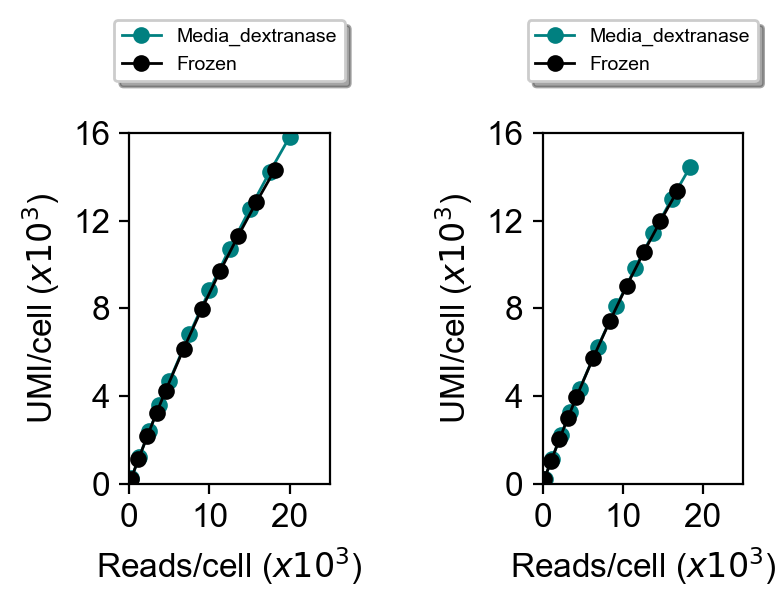

In [116]:
plot_saturation(D_cells,
                'Media_dextranase',
                'Frozen',
                ['HEK293t', '3t3'])

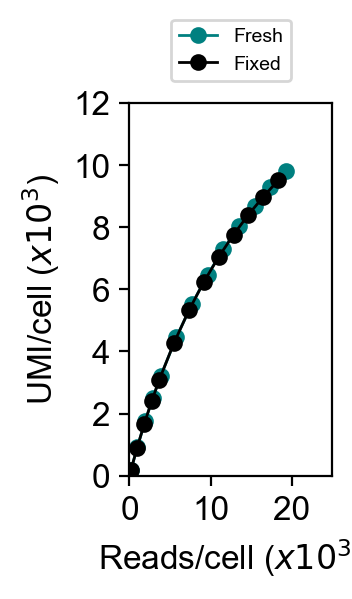

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(2.2,2.8), dpi = 200)
#Iterate over cell lines used

x = D_cells['Fresh_K562'].uns['read_sampling']
y = D_cells['Fresh_K562'].uns['umi_sampling']
ax.plot(x, y, 'o-', markersize=5, linewidth=1, label = 'Fresh', color ='teal')

x = D_cells['Fixed_K562'].uns['read_sampling']
y = D_cells['Fixed_K562'].uns['umi_sampling']
ax.plot(x, y, 'o-', markersize=5, linewidth=1, label = 'Fixed', color ='black')


ax.set_xlim(0, 25e3)
ax.set_ylim(0, 12e3)

ax.set_xlabel(r'Reads/cell ($x10^{3}$)')
ax.set_ylabel(r'UMI/cell ($x10^{3}$)')

fig.tight_layout()
ax.set_xticks([0, 10e3,  20e3])
ax.set_xticklabels([0, 10, 20])

ax.set_yticks([0, 2e3, 4e3, 6e3, 8e3, 10e3, 12e3])
ax.set_yticklabels([0, 2, 4, 6,8, 10,12])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=1, fancybox=True, shadow=False, fontsize = 7)
